In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

from typing import Optional, List

from ssvm_evaluation.plotting_utils import table__top_k_acc_per_dataset_with_significance

# Plots for the comparison of the different methods 
from ssvm_evaluation.plotting_utils import plot__03__a, plot__03__b

from ssvm_evaluation.utils import load_topk__publication

In [2]:
def _check_onlyms(reference: pd.DataFrame, others: List[pd.DataFrame], n_samples: int = 1500, random_state: Optional[int] = None):    
    # Ensure input being a list
    if isinstance(others, pd.DataFrame): 
        others = [others]
    
    # We only need to ensure, that the Only MS performance is equal
    _ref = reference[reference["scoring_method"] == "Only MS"]
    _others = [o[o["scoring_method"] == "Only MS"] for o in others if len(o) > 0]
    
    # Go over a random sub-set of rows in the reference data
    n_tests = np.zeros(len(others))
    for _, (x, y, z) in _ref[["dataset", "eval_indx", "k"]].sample(n=n_samples, random_state=random_state).drop_duplicates().iterrows():
        # Top-k accuracy of the reference
        _acc_ref = _ref[(_ref["dataset"] == x) & (_ref["eval_indx"] == y) & (_ref["k"] == z)]["top_k_acc"]

        # Top-k accuracy of the others
        _acc_others = [_o[(_o["dataset"] == x) & (_o["eval_indx"] == y) & (_o["k"] == z)]["top_k_acc"] for _o in _others]
        
        # The top-k accuracy of the reference must be equal to the one of the others
        for i in range(len(_others)):
            if len(_acc_others[i]) == 0:
                continue
            
            try: 
                # assert _acc_ref.item() ==  _acc_others[i].item()
                assert np.allclose(_acc_ref.item(), _acc_others[i].item())
            except AssertionError:
                print(i, x, y, z, _acc_ref.item(), _acc_others[i].item())
                
            n_tests[i] += 1
    
    print("Performed tests:", n_tests)

# Experiment 3: Study of LC-MS$^2$Struct ability to improve the identification of stereoisomers

In this experiment we output a score (either Only-MS$^2$ or LC-MS$^2$Struct) for each stereoisomer in the candidate set. Candidates are identified (or indexed, or distiguished) by their full InChIKey. Typically, the Only-MS$^2$ scores will be the same for a group of stereoisomers, that means for a group of candidates with the same InChIKey first block. 

By using LC-MS$^2$Struct, we hope to be able to rank the stereoisomers the correct way. To study that, we train two LC-MS$^2$Struct models for each MS$^2$ scorer: One that uses candidate fingerprints that encode chirality (3D); and one that uses fingerprint without chirality encoding (2D). The motiviation behind this experiment is, that we want to see how much rank-improvement is coming from the fact that provide the SSVM with information to distinguish between stereoisomers. 

When predicting the scores using LC-MS$^2$Struct (2D) we can observe improved ranking. Perhaps not for the stereoisomers, but generally we still capture 2D structure that improves the ranking, e.g. by ranking the correct "block" of stereoisomers higher than another "block" due to a better fitting with the observed ROs. Using the 3D features, we actually allow the LC-MS$^2$Struct (3D) to predict a different score for each candidates (each candidate now "looks different" to the ML model). Comparing the performance of 2D and 3D should give us an isign of how well we actually use the 3D information. 

## Load raw results for all three MS$^2$ scorers

In [3]:
agg_setting = {
    "marg_agg_fun": "average",
    "cand_agg_id": "inchikey"
}

### MetFrag

MetFrag performs an in-silico fragmentation for each candidate structure and compares the predicted and observed (from the MS2 spectrum) fragments. 

In [4]:
# SSVM (2D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "metfrag__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__metfrag__2D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank__with_stereo"), top_k_method="csi", load_max_model_number=True
)

# SSVM (3D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__3D", "mol_id": "cid", "ms2scorer": "metfrag__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__metfrag__3D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank__with_stereo"), top_k_method="csi", load_max_model_number=True
)

# Perform some sanity checks
assert res__ssvm__metfrag__2D["scoring_method"].nunique() == 2
assert res__ssvm__metfrag__3D["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__metfrag__2D, [res__ssvm__metfrag__3D])

Performed tests: [1500.]


#### Overview result table (LC-MS$^2$Struct)

##### Without chrirality encoding (2D)

In [5]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__metfrag__2D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                5                 10            \
scoring_method    Only MS  MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                        
AC_003  15            2.8  | 3.6 *    18.6  | 20.2 *    30.6  | 31.8 *   
AU_002  15          | 1.1    | 1.1   | 6.8       5.8  | 14.5      13.8   
BML_001 1             1.0    | 1.2  | 10.0       9.7    20.8    | 21.6   
BS_000  15         | 11.1   | 11.1  | 23.5    | 23.5    29.6    | 30.3   
EA_002  1           | 2.3      1.3  | 12.4      11.5    22.1    | 25.1   
EA_003  1             2.5    | 3.1    12.9    | 13.2    26.3    | 28.7   
EQ_004  1             1.2    | 4.2     7.9    | 19.5    23.0    | 35.8   
LQB_000 5             5.2    | 5.9    30.7    | 33.1    50.2    | 52.2   
LU_000  1             5.3    | 7.4  | 28.8      26.6  | 49.0      43.6   
LU_001  15          | 3.9      3.7    24.3    | 25.1    36.2  | 37.8 *   
NA_003  1             0.8    | 2.0     7.7    | 11.4    15.9    | 18.5   
PR_002  15            1.9    | 2.2     5.2     | 5.3   | 8.0       7.7   
RP_000  1           | 7.1      6.5    15.5    | 18.4    28.5    | 36.6   
RP_001  1             5.8    | 7.6  | 21.3      20.8    29.6    | 32.4   
SM_001  1             1.0    | 1.1    12.6    | 18.9    32.3    | 40.3   
UT_000  5             2.2    | 2.7    12.9  | 15.8 *    26.5    | 27.0   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           43.6    | 43.7  
AU_002  15           29.0    | 29.5  
BML_001 1            32.0    | 36.6  
BS_000  15           35.0  | 39.2 *  
EA_002  1            40.8    | 44.3  
EA_003  1            46.1    | 49.2  
EQ_004  1            40.3    | 48.7  
LQB_000 5            71.9    | 75.0  
LU_000  1          | 60.6      55.4  
LU_001  15         | 48.7      48.4  
NA_003  1            28.0    | 30.5  
PR_002  15         | 15.3      14.8  
RP_000  1            46.5    | 48.7  
RP_001  1            40.4    | 43.9  
SM_001  1            57.7    | 58.4  
UT_000  5            41.2    | 43.4

##### With chirality encoding (3D)

In [6]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__metfrag__3D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15            2.8   | 8.0 *    18.6  | 26.7 *    30.6  | 33.6 *   
AU_002  15            1.1   | 3.7 *     6.8  | 10.5 *    14.5  | 22.1 *   
BML_001 1             1.0     | 3.0    10.0    | 13.6    20.8    | 27.3   
BS_000  15           11.1  | 13.5 *    23.5  | 28.2 *    29.6  | 39.3 *   
EA_002  1             2.3     | 5.1    12.4    | 22.0    22.1    | 30.4   
EA_003  1           | 2.5       2.3    12.9    | 17.5    26.3    | 33.3   
EQ_004  1             1.2     | 6.5     7.9    | 20.6    23.0    | 35.3   
LQB_000 5             5.2  | 25.5 *    30.7  | 50.1 *    50.2  | 63.5 *   
LU_000  1           | 5.3       4.0    28.8    | 34.0  | 49.0      48.7   
LU_001  15            3.9   | 7.3 *    24.3  | 25.8 *    36.2  | 39.6 *   
NA_003  1             0.8     | 2.7     7.7    | 15.1    15.9    | 26.7   
PR_002  15            1.9   | 2.9 *     5.2   | 7.5 *     8.0  | 11.9 *   
RP_000  1             7.1     | 8.6    15.5    | 22.9    28.5    | 40.0   
RP_001  1             5.8     | 6.8  | 21.3      16.4    29.6    | 35.6   
SM_001  1             1.0     | 3.3    12.6    | 22.2    32.3    | 33.3   
UT_000  5             2.2   | 6.7 *    12.9  | 25.8 *    26.5  | 39.7 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           43.6    | 45.1  
AU_002  15           29.0  | 38.0 *  
BML_001 1            32.0    | 39.4  
BS_000  15           35.0  | 47.0 *  
EA_002  1            40.8    | 46.4  
EA_003  1            46.1    | 54.4  
EQ_004  1            40.3    | 49.0  
LQB_000 5            71.9  | 81.7 *  
LU_000  1            60.6    | 62.0  
LU_001  15           48.7  | 56.5 *  
NA_003  1            28.0    | 35.6  
PR_002  15           15.3  | 17.6 *  
RP_000  1            46.5    | 52.2  
RP_001  1            40.4    | 46.6  
SM_001  1            57.7    | 63.3  
UT_000  5            41.2  | 57.8 *

## SIRIUS

In [7]:
# SSVM (2D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "sirius__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__sirius__2D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank__with_stereo"), top_k_method="csi", load_max_model_number=True
)

# SSVM (3D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__3D", "mol_id": "cid", "ms2scorer": "sirius__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__sirius__3D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank__with_stereo"), top_k_method="csi", load_max_model_number=True
)

# Perform some sanity checks
assert res__ssvm__sirius__2D["scoring_method"].nunique() == 2
assert res__ssvm__sirius__3D["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__sirius__2D, [res__ssvm__sirius__3D])

Performed tests: [1500.]


#### Overview result table (LC-MS$^2$Struct)

##### Without chrirality encoding (2D)

In [8]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__sirius__2D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                5                 10            \
scoring_method    Only MS  MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                        
AC_003  15            5.5  | 5.8 *    24.2  | 24.6 *  | 39.3    | 39.3   
AU_002  15            5.5    | 5.6  | 23.6      23.5  | 34.7      34.6   
BML_001 1           | 6.0    | 6.0    29.0    | 31.0  | 41.4    | 41.4   
BS_000  15         | 13.4   | 13.4  | 34.3      34.2    45.3  | 46.0 *   
EA_002  1           | 6.5      5.9  | 28.2      27.5  | 39.1    | 39.1   
EA_003  1           | 7.7      7.6  | 31.4      30.1  | 45.8      45.2   
EQ_004  1             4.1    | 4.6    24.4    | 25.5    43.1    | 43.7   
LQB_000 5           | 5.5    | 5.5  | 24.9      24.8    37.2    | 37.4   
LU_000  1             2.6    | 3.9    17.2    | 17.4    34.0    | 34.5   
LU_001  15            4.5    | 4.6    25.8    | 26.1    36.7    | 37.3   
NA_003  1           | 2.7    | 2.7  | 18.0      17.4  | 31.4      31.1   
PR_002  15          | 6.3      6.2  | 22.9    | 22.9    33.1    | 33.4   
RP_000  1             8.2    | 8.6    31.0    | 36.5  | 45.4      45.3   
RP_001  1          | 12.8   | 12.8    42.1    | 42.6  | 53.1      51.1   
SM_001  1             6.7    | 7.8    36.1    | 37.2  | 58.6    | 58.6   
UT_000  5          | 15.2     14.9    30.9    | 31.2  | 36.2    | 36.2   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15         | 53.0    | 53.0  
AU_002  15         | 48.1      47.8  
BML_001 1          | 52.0    | 52.0  
BS_000  15         | 60.6      59.8  
EA_002  1          | 53.9    | 53.9  
EA_003  1          | 64.2      64.0  
EQ_004  1          | 58.2      57.6  
LQB_000 5          | 57.5      57.2  
LU_000  1          | 50.1      50.0  
LU_001  15           58.3  | 59.1 *  
NA_003  1            48.2    | 48.3  
PR_002  15           51.0    | 51.1  
RP_000  1          | 61.2      59.3  
RP_001  1          | 60.3      59.9  
SM_001  1          | 66.3    | 66.3  
UT_000  5          | 44.7      44.6

##### With chirality encoding (3D)

In [9]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__sirius__3D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15            5.5     | 6.5    24.2  | 29.2 *    39.3  | 43.7 *   
AU_002  15            5.5   | 9.4 *    23.6  | 35.9 *    34.7  | 47.0 *   
BML_001 1             6.0    | 21.2    29.0    | 36.4    41.4    | 42.4   
BS_000  15           13.4  | 17.9 *    34.3  | 40.9 *    45.3  | 52.7 *   
EA_002  1             6.5    | 10.1    28.2    | 35.7    39.1    | 43.7   
EA_003  1             7.7    | 14.6    31.4    | 42.7    45.8    | 61.4   
EQ_004  1           | 4.1       2.0    24.4    | 34.6    43.1    | 49.0   
LQB_000 5             5.5  | 15.4 *    24.9  | 33.7 *    37.2  | 49.5 *   
LU_000  1             2.6     | 6.0    17.2    | 20.0    34.0    | 35.0   
LU_001  15            4.5   | 7.7 *    25.8  | 33.8 *    36.7  | 46.5 *   
NA_003  1             2.7     | 4.1    18.0    | 22.1    31.4    | 42.5   
PR_002  15            6.3     | 7.0    22.9  | 28.0 *    33.1  | 37.7 *   
RP_000  1           | 8.2       2.9    31.0    | 37.1  | 45.4      42.9   
RP_001  1            12.8    | 13.5    42.1    | 47.9    53.1    | 56.2   
SM_001  1             6.7    | 14.4    36.1    | 38.9    58.6    | 63.3   
UT_000  5            15.2  | 19.9 *    30.9    | 32.5    36.2  | 39.4 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           53.0  | 55.1 *  
AU_002  15           48.1  | 54.7 *  
BML_001 1          | 52.0      51.5  
BS_000  15           60.6  | 63.7 *  
EA_002  1            53.9    | 58.9  
EA_003  1            64.2    | 73.7  
EQ_004  1            58.2    | 68.6  
LQB_000 5            57.5  | 65.4 *  
LU_000  1            50.1    | 54.0  
LU_001  15           58.3  | 65.0 *  
NA_003  1            48.2    | 53.4  
PR_002  15           51.0  | 54.2 *  
RP_000  1          | 61.2      57.1  
RP_001  1            60.3    | 61.6  
SM_001  1            66.3    | 73.3  
UT_000  5            44.7  | 50.0 *

## CFM-ID

In [10]:
# SSVM (2D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__cfmid4__2D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank__with_stereo"), top_k_method="csi", load_max_model_number=True
)

# SSVM (3D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__3D", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__cfmid4__3D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank__with_stereo"), top_k_method="csi", load_max_model_number=True
)

# Perform some sanity checks
assert res__ssvm__cfmid4__2D["scoring_method"].nunique() == 2
assert res__ssvm__cfmid4__3D["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__cfmid4__2D, [res__ssvm__cfmid4__3D])

Performed tests: [1500.]


#### Overview result table (LC-MS$^2$Struct)

##### Without chrirality encoding (2D)

In [11]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__cfmid4__2D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                5                 10            \
scoring_method    Only MS  MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                        
AC_003  15            1.1  | 1.3 *     8.7  | 10.0 *    18.2  | 20.3 *   
AU_002  15            0.8  | 1.0 *     4.9   | 5.8 *     9.7  | 11.1 *   
BML_001 1             0.0    | 0.1     6.6     | 8.1  | 17.2      16.2   
BS_000  15            7.6  | 8.0 *    16.1    | 16.7    23.0  | 25.1 *   
EA_002  1             0.1    | 0.8     5.9     | 6.5  | 12.7      12.5   
EA_003  1           | 1.2    | 1.2     8.3     | 8.9    14.6    | 15.1   
EQ_004  1             2.9    | 3.8    11.7    | 14.6    22.0    | 22.2   
LQB_000 5             4.8  | 7.6 *    34.7  | 37.9 *    55.5    | 57.8   
LU_000  1           | 1.5    | 1.5   | 9.5       8.9  | 26.6      22.0   
LU_001  15            2.3    | 2.5    14.1  | 15.7 *  | 26.6      26.5   
NA_003  1             0.2    | 0.5     2.8     | 4.2     5.5     | 8.5   
PR_002  15            1.8    | 1.9   | 7.0       6.0  | 13.7      12.9   
RP_000  1             5.7    | 7.1    14.9    | 18.3    25.8    | 27.6   
RP_001  1             3.2    | 4.3    14.4    | 15.1  | 25.1      24.8   
SM_001  1             1.1    | 2.2    10.0    | 13.3    26.0    | 27.4   
UT_000  5             7.1    | 7.7    30.3    | 31.3    48.4    | 49.6   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           29.8  | 33.8 *  
AU_002  15           17.9  | 23.4 *  
BML_001 1            29.6    | 31.0  
BS_000  15           30.9  | 35.2 *  
EA_002  1            24.6    | 26.3  
EA_003  1            27.8    | 29.3  
EQ_004  1            33.9    | 36.1  
LQB_000 5            75.3  | 79.3 *  
LU_000  1            43.9    | 48.4  
LU_001  15           35.6  | 38.3 *  
NA_003  1          | 13.9      13.7  
PR_002  15           23.0  | 25.1 *  
RP_000  1            31.9    | 35.9  
RP_001  1            33.8    | 35.1  
SM_001  1            38.9    | 40.8  
UT_000  5            64.1    | 66.2

##### With chirality encoding (3D)

In [12]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__cfmid4__3D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15            1.1   | 2.1 *     8.7  | 13.2 *    18.2  | 24.4 *   
AU_002  15            0.8   | 2.4 *     4.9   | 8.2 *     9.7  | 16.3 *   
BML_001 1           | 0.0     | 0.0     6.6    | 15.2    17.2    | 21.2   
BS_000  15            7.6   | 9.2 *    16.1  | 22.7 *    23.0  | 30.3 *   
EA_002  1             0.1     | 1.8     5.9     | 7.1    12.7    | 14.3   
EA_003  1           | 1.2       0.0   | 8.3       7.6    14.6    | 17.5   
EQ_004  1             2.9     | 3.9    11.7    | 17.6    22.0    | 31.4   
LQB_000 5             4.8  | 22.8 *    34.7  | 56.3 *    55.5  | 70.4 *   
LU_000  1             1.5     | 2.0     9.5    | 12.0    26.6    | 32.0   
LU_001  15            2.3   | 4.4 *    14.1  | 18.7 *    26.6  | 32.1 *   
NA_003  1           | 0.2       0.0     2.8     | 6.8     5.5    | 12.3   
PR_002  15            1.8   | 2.7 *     7.0  | 10.7 *    13.7  | 18.3 *   
RP_000  1           | 5.7     | 5.7    14.9    | 20.0    25.8    | 29.5   
RP_001  1             3.2     | 8.2    14.4    | 19.2    25.1    | 28.8   
SM_001  1             1.1     | 3.3    10.0    | 11.1    26.0    | 30.0   
UT_000  5             7.1  | 14.9 *    30.3  | 47.5 *    48.4  | 60.1 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           29.8  | 37.6 *  
AU_002  15           17.9  | 31.2 *  
BML_001 1            29.6    | 33.3  
BS_000  15           30.9  | 42.4 *  
EA_002  1            24.6    | 26.8  
EA_003  1            27.8    | 33.3  
EQ_004  1            33.9    | 41.2  
LQB_000 5            75.3  | 84.1 *  
LU_000  1            43.9    | 54.0  
LU_001  15           35.6  | 42.0 *  
NA_003  1            13.9    | 16.4  
PR_002  15           23.0  | 30.8 *  
RP_000  1            31.9    | 40.0  
RP_001  1            33.8    | 42.5  
SM_001  1            38.9    | 46.7  
UT_000  5            64.1  | 76.3 *

## Visualization of the ranking performance

Top-k curve for each MS2-scoring method: CFM-ID, MetFrag and SIRIUS.

We expect 4700 result rows
Rows (MS2-scorer='CFM-ID'):
Number of samples: 94
Baseline:  4700
SSVM (2D):  4700
	top-1: baseline = 3.0%, other = 3.4%, improvement = 0.4%p, gain = 13.8%, n = 0.2
	top-20: baseline = 32.3%, other = 35.8%, improvement = 3.5%p, gain = 10.8%, n = 1.8
SSVM (3D):  4700
	top-1: baseline = 3.0%, other = 5.6%, improvement = 2.6%p, gain = 87.3%, n = 1.4
	top-20: baseline = 32.3%, other = 41.4%, improvement = 9.2%p, gain = 28.5%, n = 4.7
Rows (MS2-scorer='MetFrag'):
Number of samples: 94
Baseline:  4700
SSVM (2D):  4700
	top-1: baseline = 4.0%, other = 4.3%, improvement = 0.3%p, gain = 7.7%, n = 0.2
	top-20: baseline = 37.6%, other = 38.7%, improvement = 1.2%p, gain = 3.1%, n = 0.6
SSVM (3D):  4700
	top-1: baseline = 4.0%, other = 7.8%, improvement = 3.8%p, gain = 95.9%, n = 2.0
	top-20: baseline = 37.6%, other = 44.8%, improvement = 7.2%p, gain = 19.1%, n = 3.7
Rows (MS2-scorer='SIRIUS'):
Number of samples: 94
Baseline:  4700
SSVM (2D):  4700
	top-1: baseline = 7.3%

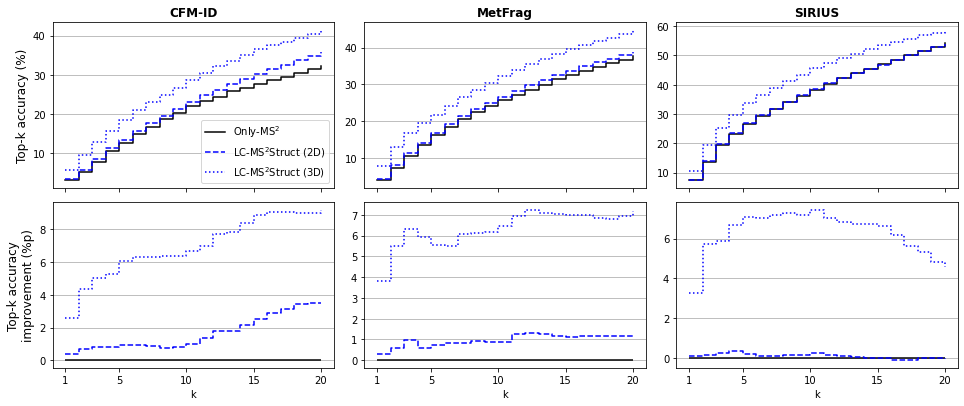

In [13]:
__tmp__03__a = plot__03__a(
    res__baseline=[
        res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "Only MS") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="CFM-ID"),
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "Only MS") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "Only MS") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
    ], 
    res__ssvm__2D=[
        res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="CFM-ID"),
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="SIRIUS")
    ],
    res__ssvm__3D=[
        res__ssvm__cfmid4__3D[(res__ssvm__cfmid4__3D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="CFM-ID"),
        res__ssvm__metfrag__3D[(res__ssvm__metfrag__3D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__3D[(res__ssvm__sirius__3D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="SIRIUS")
    ],
    max_k=20,
    weighted_average=False,
    raise_on_missing_results=True,
    aspect="landscape",
    verbose=True
)

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_03__a", ext])))

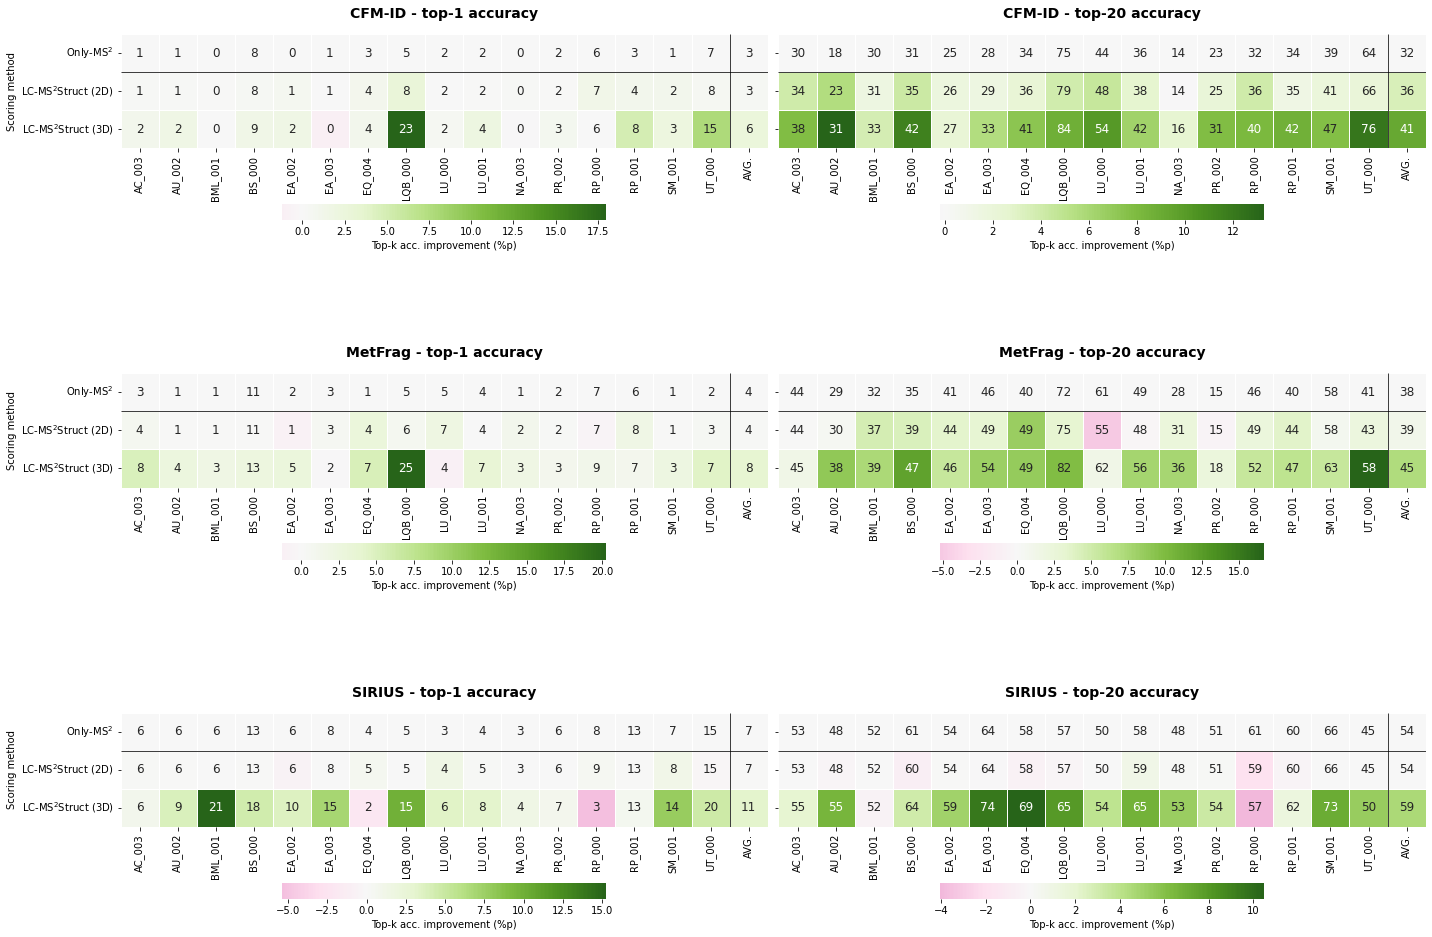

In [14]:
__tmp__03__b = plot__03__b(
    res__baseline=[
        res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "Only MS") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="CFM-ID"),
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "Only MS") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "Only MS") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
    ], 
    res__ssvm__2D=[
        res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="CFM-ID"),
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="SIRIUS")
    ],
    res__ssvm__3D=[
        res__ssvm__cfmid4__3D[(res__ssvm__cfmid4__3D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="CFM-ID"),
        res__ssvm__metfrag__3D[(res__ssvm__metfrag__3D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__3D[(res__ssvm__sirius__3D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="SIRIUS")
    ],
    ks=[1, 20],
    weighted_average=False,
    raise_on_missing_results=True,
    ctype="improvement",
    label_format=".0f"
)

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_03__b", ext])))